In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d
from polynomial import Polynomial
from sklearn.manifold import TSNE
from IPython.display import display, Math

In [2]:
INPUT_DIM = 15
USED_INPUT_DIM = 10  # We define a polynomial using this amount of input dimensions
N_MONOMIALS = 20
HIDDEN_DIM = 100
MAX_DEGREE = 3

In [3]:
torch.set_default_dtype(torch.double)

In [4]:
# Get cpu or gpu device for training.
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"  # CPU is faster in our use case
print(f"Using {device} device")

Using cpu device


In [5]:
def train(dataloader, model, loss_fn, optimizer, print_frequency=0):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        model.force_non_negative_exponents_()

        if print_frequency > 0 and batch % print_frequency == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [6]:
def test(dataloader, model, loss_fn, print_loss=True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    if print_loss:
        print(f"Test Error: Avg loss: {test_loss:>8f} \n")
    return test_loss

In [7]:
def tensor_to_numpy(tensor):
    return tensor.detach().cpu().numpy().copy()

class LogActivation(nn.Module):
    def forward(self, x):
        return torch.log(x)
    
class ExpActivation(nn.Module):
    def forward(self, x):
        return torch.exp(x)

# Define model
class PolynomialNN(nn.Module):
    def __init__(self, n_inputs=1, n_monomials=1, exponent_bias=True):
        super(PolynomialNN, self).__init__()
        self.stack = nn.Sequential(
            LogActivation(),
            nn.Linear(n_inputs, n_monomials, bias=exponent_bias),
            ExpActivation(),
            nn.Linear(n_monomials, 1)
        )
        self.exponent_bias = exponent_bias
        
    def forward(self, x):
        x = self.stack(x)
        return x
    
    @property
    def exponent_layer(self):
        return self.stack[1]
    
    @property
    def coefficient_layer(self):
        return self.stack[3]
    
    def get_exponents(self):
        return tensor_to_numpy(self.stack[1].weight)
    
    def get_coefficients(self):
        coefficients = tensor_to_numpy(self.coefficient_layer.weight)
        if self.exponent_bias:
            coefficients *= np.exp(tensor_to_numpy(self.exponent_layer.bias))
        return coefficients
    
    def get_bias(self):
        return tensor_to_numpy(self.coefficient_layer.bias)
    
    def exponents_abs_(self):
        self.exponent_layer.weight.abs_()
        
    def force_non_negative_exponents_(self):
        with torch.no_grad():
            self.exponent_layer.weight.clamp_(0.)

In [8]:
# Define Data
class DatasetFromFunction(Dataset):
    def __init__(self, sample_fn, target_fn, size, noise_fn = None, positive_only=False):
        self.size = size
        self.x = sample_fn(self.size)
        if positive_only:
            self.x = torch.abs(self.x)
        self.y = target_fn(self.x)
        self.noise = torch.zeros_like(self.y)
    
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def normalize_target(self, mean, std):
        self.y = (self.y - mean)/std
        
    def add_noise(self, noise_fn):
        self.noise += noise_fn(self.size)
        self.y += self.noise

In [9]:
def truncated_normal(shape, min_val, rng=None, mean=0., std=1.):
    normal_sample = lambda: torch.normal(mean, std, shape, generator=rng)
    x = normal_sample()
    while (x < min_val).any():
        x_new = normal_sample()
        x[x < min_val] = x_new[x < min_val]
    return x

# Convergence Experiments

Generate the training and test set

The non-scaled target polynomial has 0 non-constant monomials
The non-scaled target polynomial is


<IPython.core.display.Math object>

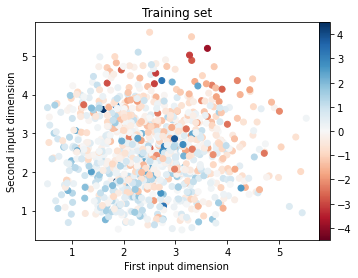

In [10]:
rng = torch.Generator(device="cpu")
rng.manual_seed(0)
sample_fn = lambda n: truncated_normal((n, INPUT_DIM), 0.5, rng, mean=2.5)
np.random.seed(2818)
target_fn = Polynomial.from_random_monomials(max_index=USED_INPUT_DIM,
                                             n_monomials=N_MONOMIALS,
                                             degree_distribution=lambda: np.random.randint(1,MAX_DEGREE+1),
                                             coefficient_distribution=np.random.normal)
                                             
training_data = DatasetFromFunction(sample_fn, target_fn, 1000)
val_data = DatasetFromFunction(sample_fn, target_fn, 100)
test_data = DatasetFromFunction(sample_fn, target_fn, 100)

# Normalize targets
target_mean = torch.mean(training_data.y)
target_std = torch.std(training_data.y)
training_data.normalize_target(target_mean, target_std)
val_data.normalize_target(target_mean, target_std)
test_data.normalize_target(target_mean, target_std)

# Add gaussian noise
noise_fn = lambda n: torch.normal(0, .1, (n,1), generator=rng)
training_data.add_noise(noise_fn)
test_data.add_noise(noise_fn)
val_data.add_noise(noise_fn)

train_dataloader = DataLoader(training_data, batch_size=128, shuffle=True)
val_dataloader = DataLoader(training_data, batch_size=128)
test_dataloader = DataLoader(test_data, batch_size=128)

vmax = training_data.y.abs().max()
vmin = -vmax
plt.scatter(training_data.x[:, 0], training_data.x[:, 1], cmap='RdBu', c=training_data.y, vmin=vmin, vmax=vmax)
plt.colorbar(pad=0)
plt.title("Training set")
plt.xlabel("First input dimension")
plt.ylabel("Second input dimension")

print(f"The non-scaled target polynomial has {np.count_nonzero(len(target_fn))-1} non-constant monomials")
print(f"The non-scaled target polynomial is")
display(Math(target_fn.latex_string(precision=1)))

Initialize the model

In [11]:
torch.manual_seed(6825)
model = PolynomialNN(INPUT_DIM, HIDDEN_DIM, False).to(device)
with torch.no_grad():
    model.exponent_layer.weight.data.uniform_(0.0, 2/INPUT_DIM)
print(model)

PolynomialNN(
  (stack): Sequential(
    (0): LogActivation()
    (1): Linear(in_features=15, out_features=100, bias=False)
    (2): ExpActivation()
    (3): Linear(in_features=100, out_features=1, bias=True)
  )
)


Train the model

In [12]:
loss_fn = nn.MSELoss()
exponent_path_list = [model.get_exponents()]
coefficient_path_list = [model.get_coefficients()]
bias_path_list = [model.get_bias()]
loss_path = [test(test_dataloader, model, loss_fn, False)]
total_epochs = 0

In [13]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, nesterov=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=200, verbose=True, factor=0.1**(1/3))

In [14]:
epochs = 30000
for t in tqdm(range(epochs)):
    train(train_dataloader, model, loss_fn, optimizer)
    scheduler.step(test(val_dataloader, model, loss_fn, False))
    exponent_path_list.append(model.get_exponents())
    coefficient_path_list.append(model.get_coefficients())
    bias_path_list.append(model.get_bias())
    loss_path.append(test(test_dataloader, model, loss_fn, False))
    total_epochs += 1
test(test_dataloader, model, loss_fn)
print("Done!")

 17%|███████████▊                                                          | 5038/30000 [01:08<05:37, 73.92it/s]

Epoch  5024: reducing learning rate of group 0 to 4.6416e-04.


 95%|█████████████████████████████████████████████████████████████████▌   | 28525/30000 [06:56<00:20, 70.57it/s]

Epoch 28519: reducing learning rate of group 0 to 2.1544e-04.


100%|█████████████████████████████████████████████████████████████████████| 30000/30000 [07:17<00:00, 68.60it/s]

Test Error: Avg loss: 0.017166 

Done!


Text(0.5, 1.0, 'Test Loss')

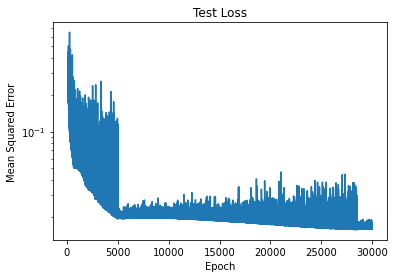

In [15]:
loss_start_epoch = 100
plt.plot(range(loss_start_epoch, total_epochs+1), loss_path[loss_start_epoch:])
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.yscale("log")
plt.title("Test Loss")

In [16]:
# Condense paths into arrays
exponent_path = np.stack(exponent_path_list)
coefficient_path = np.stack(coefficient_path_list)[:,0,:]
bias_path = np.stack(bias_path_list)
coefficient_path = np.hstack([bias_path, coefficient_path])  # Add the bias as the coefficient of the constant monomial 1

# Undo the target scaling for the coefficient path
coefficient_path *= target_std.numpy()
coefficient_path[:, 0] += target_mean.numpy()

### Plot learned monomial degrees

In [17]:
smoothing_sd = .03  # used to determine the confidence interval of a learned exponent
max_plot_epochs = 1000  # determines how many epochs we sample
if max_plot_epochs < total_epochs:
    x = np.linspace(0, total_epochs, max_plot_epochs, dtype=np.int32)
else:
    x = np.arange(total_epochs+1)

degree_bins = 1000
y_min = -4 * smoothing_sd
y_max = max(exponent_path.sum(axis=-1).max(), MAX_DEGREE) + 4*smoothing_sd
learned = np.zeros((degree_bins, x.size))
for i, epoch in enumerate(x):
    learned_degrees = exponent_path[epoch].sum(axis=-1)
    learned_degrees = np.pad(learned_degrees, (1, 0)) # add constant monomial
    weights = coefficient_path[epoch]
    hist, bin_edges = np.histogram(learned_degrees, degree_bins, (y_min, y_max), weights=weights)
    learned[:, i] = hist
learned = gaussian_filter1d(learned, smoothing_sd * degree_bins/y_max, axis=0) 

hist, bin_edges = np.histogram(
    target_fn.degrees(),
    degree_bins,
    (y_min, y_max),
    weights=target_fn.coefficients
)
ground_truth = gaussian_filter1d(hist, smoothing_sd * degree_bins/y_max, axis=0)
ground_truth = ground_truth[:, None]

y = bin_edges[:-1] + (bin_edges[1] - bin_edges[0])/2

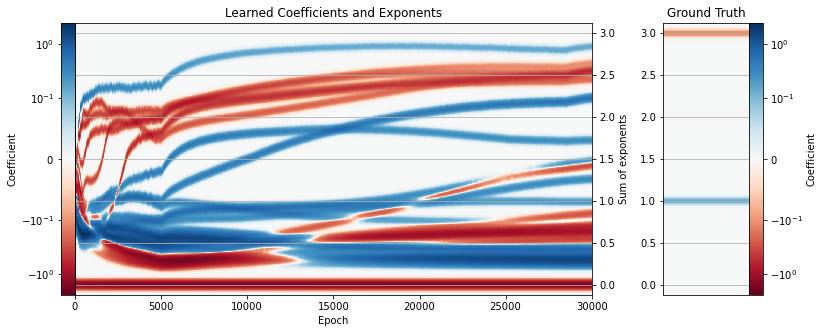

In [18]:
vmax = max(np.abs(learned).max(),  ground_truth.max())
vmin = -vmax
norm = mcolors.SymLogNorm(.1, vmin=vmin, vmax=vmax)
cmap = "RdBu"

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw=dict(width_ratios=[6,1]))
pcm = ax1.pcolormesh(x, y, learned, cmap=cmap, norm=norm, edgecolors=None)
fig.colorbar(pcm, ax=ax1, label="Coefficient", pad=0, location="left")
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")
ax1.set_ylabel("Sum of exponents")
ax1.set_xlabel("Epoch")
ax1.set_title("Learned Coefficients and Exponents")
ax1.grid(True, axis='y')

pcm = ax2.pcolormesh([0,1], bin_edges, ground_truth, cmap=cmap, norm=norm, edgecolors=None)
fig.colorbar(pcm, ax=ax2, label="Coefficient", pad=0)
ax2.set_title("Ground Truth")
ax2.xaxis.set_visible(False)
ax2.grid(True, axis='y')

# TSNE MAPPING OF LEARNED EXPONENTS

(20, 15) (100, 15)


C:\Users\sgreg\miniconda3\envs\pfl\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


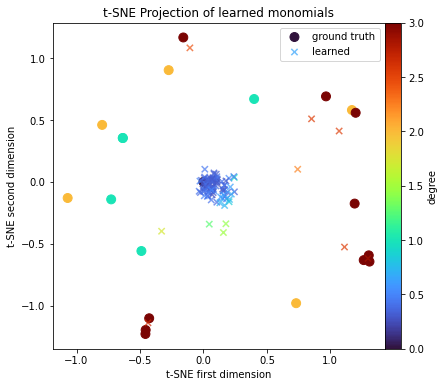

In [22]:
exps = target_fn.get_exponents(INPUT_DIM)
print(exps.shape, learned_exps.shape)
all_exps = np.vstack([np.zeros(INPUT_DIM), exps, learned_exps])
degrees = all_exps.sum(axis=1)
embedding = TSNE(perplexity=100., learning_rate='auto', init='pca').fit_transform(all_exps)
embedding-= embedding[0]

fig, ax = plt.subplots(1, 1, figsize=(7,6))
vmin = 0
vmax = all_exps.max()
cmap = "turbo"

# Plot ground truth
x, y = embedding[:-len(learned_exps)].T
c = degrees[:-len(learned_exps)]
sct = ax.scatter(x, y, c=c, marker="o", alpha=1., s=80, label="ground truth", cmap=cmap, vmin=vmin, vmax=vmax)
fig.colorbar(sct, pad=0, label="degree", ax=ax)
# Plot learned monomials
x, y = embedding[-len(learned_exps):].T
c = degrees[-len(learned_exps):]
ax.scatter(x, y, c=c, marker="x", alpha=0.7, s=40, label="learned", cmap=cmap, vmin=vmin, vmax=vmax)
ax.legend()
ax.set_title("t-SNE Projection of learned monomials")
ax.set_xlabel("t-SNE first dimension")
ax.set_ylabel("t-SNE second dimension")
plt.show()

Text(0, 0.5, 'Degree')

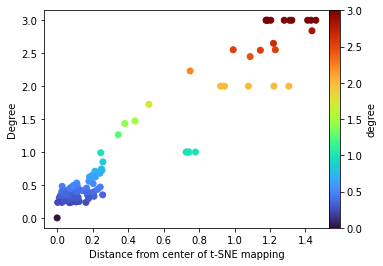

In [24]:
x = (embedding**2).sum(axis=1)**.5
y = all_exps.sum(axis=1)
plt.scatter(x, y, c=degrees, cmap=cmap)
plt.colorbar(pad=0, label="degree")
plt.xlabel("Distance from center of t-SNE mapping")
plt.ylabel("Degree")